<a href="https://colab.research.google.com/github/Cbilinski/AstroDeepLearning_Hackathon/blob/main/CNN_Galaxy_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Galaxy Classification using Deep Learning
By Ansh Gupta - 02/23/2024

Today, you are going to get hands-on experience making your very own machine learning models! This is a big step towards building your practical understanding of ML, and I hope this exercise encourages you to think about how you these techniques in your research. The problem we are trying to solve today is one that is very relevant in actual astronomical and machine learning research! Hopefully, after working through this notebook, you will understand the basic structure of how to train and evaluate models and can begin to make and deploy your very own.

## PLEASE TAKE OUR SURVEY ONCE YOU'RE DONE!
It really helps us make the session better for you guys and gives us extremely valuable feedback. Thank you!

https://bit.ly/DeepHackFeedback

# MAKE SURE YOU SAVE A COPY OF THIS NOTEBOOK BEFORE YOU DO ANYTHING OR YOUR PROGRESS WILL NOT SAVE. ALSO MAKE SURE YOU ARE CONNECTED TO THE T4 GPU!

# Background

In the past few years (now decades, yikes!), programs like the Sloan Digital Sky Survey (SDSS) have revolutionized extragalactic astronomy and cosmology. The goal of these surveys is to create a 3-dimensional map of galaxies, quasars, and other objects in order to probe the structure of the universe on large scales. To do this, we need to know the distances to many thousands or millions of galaxies.

Astronomers can measure distances to distant objects by calculating their "redshift". The expansion of the universe causes light travelling between us and distance sources to be stretched out, meaning that distant objects appear redder than nearby ones. We can quantify the redshift of sources by taking spectra of them, and that's exactly what surveys like SDSS do.

A major part of developing and designing surveys is "target selection". Taking spectra is extremely expensive. SDSS used to require physical metal plates to be made with physical holes drilled in. Individual fiber optic cables would be plugged into these holes by hand, allowing spectra of multiple objects in the sky to be taken at once. Nowdays, modern surveys use tiny robots to position fiber optic cables - thousands at a time!

In order to identify good candidates to take spectra of, these surveys use a set of imaging surveys for basic selection. These images (photometry) are very cheap in comparison, and help narrow down the best objects to focus on for spectroscopy. We will be analyzing images from the DESI Legacy Imaging Surveys, a program that was used to select candidates to be observed by the [Dark Energy Spectroscopic Instrument](https://www.desi.lbl.gov/)

# Setup and Download Dataset

The dataset we are using is called Galaxy10 DECals. This is an improved version of an earlier dataset called Galaxy10, which used images from SDSS. Galaxy10 DECals includes images from a subset of the DESI Legacy Imaging Surveys. You can read more about it [here](https://astronn.readthedocs.io/en/latest/galaxy10.html).

The data consists of images of galaxies with a resolution of 256x256 pixels in 3 color channels. There are 10 unique types of galaxies in the dataset. Every image comes with a label which tells you which class each galaxy belongs to. If we train a ML model on the images, these labels are the "answer key".

In [3]:
# Download the dataset onto the disk
!wget https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5

--2024-02-23 21:33:46--  https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5
Resolving www.astro.utoronto.ca (www.astro.utoronto.ca)... 128.100.89.92
Connecting to www.astro.utoronto.ca (www.astro.utoronto.ca)|128.100.89.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2735267419 (2.5G)
Saving to: ‘Galaxy10_DECals.h5.1’

Galaxy10_DECals.h5. 100%[===================>]   2.55G  18.9MB/s    in 3m 30s  

2024-02-23 21:37:16 (12.4 MB/s) - ‘Galaxy10_DECals.h5.1’ saved [2735267419/2735267419]



In [4]:
# Basic imports to load in and visualize the data - you definitely need these
import h5py
import numpy as np
import matplotlib.pyplot as plt

# I had in mind to use tensorflow, but feel free to use pytorch if you prefer
import tensorflow as tf
from tensorflow.keras import utils, layers, models, Model
from tensorflow.keras.models import Sequential

# I didn't use these but if you want to process the data differently you can.
# Not advised for beginners since I already have the data processed for you!
# import PIL
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.utils import shuffle

In [5]:
# To get the images and labels from file
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    N_images = 2000
    random_indices = np.random.choice(range(17736), size=N_images, replace=False)
    random_indices.sort()

    images = F['images'][random_indices]
    labels = F['ans'][random_indices]

In [6]:
img_height = 256
img_width = 256
channels = 3
num_classes = 10
batch_size = 32

In [7]:
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset = dataset.batch(batch_size)

In [8]:
train_ds, val_ds = utils.split_dataset(dataset, left_size=0.8, shuffle=True, seed=42)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

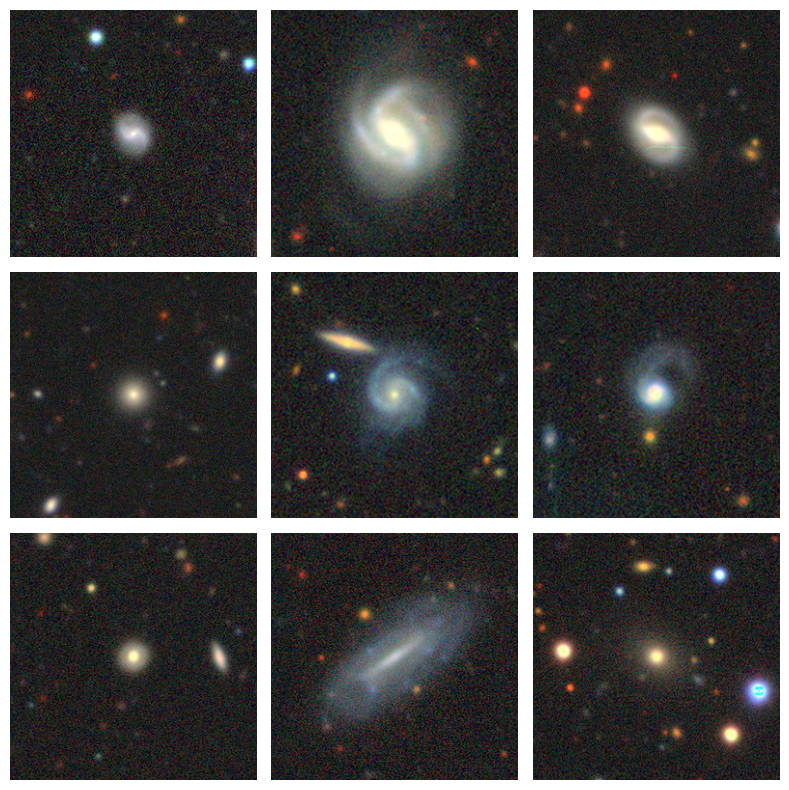

In [10]:
plt.figure(figsize=(8, 8))
for X, Y in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i].numpy().astype("uint8"))
        plt.axis("off")
plt.tight_layout()

# READ BEFORE MOVING ON

I have structured this notebook so that people of all experience levels will be challenged. I have snippets of code which you can use as a starting place. As you go further down the notebook, this code gets more and more detailed. So for example, absolute beginners may want to start towards the bottom, whereas people with lots of experience can start towards the top.

Please try to solve as much as you can before moving on and revealing more hints. If you get stuck, you can raise your hand and I can help, or you can ask people at your table to work together and brainstorm solutions. The code snippets I provide are only meant to be a starting point if you have no clue where to start. Thanks for reading and happy coding!

# Section 1: Machine Learning Experts

Open this section if you are an expert and machine learning that doesn't really need help and can independently solve ML problems. You will try to design your own model from scratch and try to beat my record.

If you are an expert in machine learning who uses ML in their research or is very familiar with how to make your own models, I highly encourage you to start from scratch. You probably don't need me to tell you what to do, so just start with the data I have given you and try to make a model that is as good as possible! The very best I could get is a 60% validation accuracy - try and beat that record if you can! 80% or 90% is the very best I saw while browsing papers which analyzed this dataset.

# Section 2: Advanced Students/Researchers

Open this section if you have some limited knowledge making maching learning models but not necessarily from scratch. You will be given a framework to develop your model but I won't give you much else. Good luck!

I will give you a basic outline for trying to build and test a model. Try to figure out a design that can get a decent validation accuracy. The best I could get is about 60%, but if you get to 30% with a simple model that would be quite successful!

The outline is a sequential model, which stacks a bunch of layers on top of eachother. In this section, I will not give you any guidance on how to build up these layers. You can see the available options [here](
https://www.tensorflow.org/api_docs/python/tf/keras/layers)

If you want some basic advice, but no specifics, here is an [article](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7) which talks about how you might design a CNN architecture.


In [ ]:
model = Sequential([
    layers.yourlayername(...)
    # Add a bunch of layers like this! Good luck
])

In [ ]:
model.compile(optimizer='your optimizer',
              loss='your loss',
              metrics=['your metrics'])

In [ ]:
epochs=10 # feel free to adjust
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Let's see how good you did!

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Section 3: Intermediate Students/Researchers

Open this section if you have some amount of experience solving ML problems starting off with a pre-defined architecture or tweaking existing models to solve a basic task. I will give you an outline and the right kinds of building blocks so you don't have to start from scratch, but you'll get good practice building a CNN and thinking about what layers to stack to accomplish different goals.

I will give you a basic outline for trying to build and test a model. Try to figure out a design that can get a decent validation accuracy. The best I could get is about 60%, but if you get to 30% with a simple model that would be quite successful!

The outline is a sequential model, which stacks a bunch of layers on top of eachother. In this section, I will not give you any guidance on how to build up these layers. You can see the available options [here](
https://www.tensorflow.org/api_docs/python/tf/keras/layers)

If you want some basic advice, but no specifics, here is an [article](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7) which talks about how you might design a CNN architecture.


In [75]:
# model = Sequential([
#     data_augmentation,
#     layers.Rescaling(1./255),

model = Sequential([
    data_augmentation,
    # This layer normalizes the data, making training more efficient
    layers.Rescaling(1./255, input_shape=(img_height, img_width, channels)),

    # Here are some examples of some layers you might stack together
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (4,4), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (5,5), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# model = Sequential([
#     # This layer normalizes the data, making training more efficient
#     layers.Rescaling(1./255, input_shape=(img_height, img_width, channels)),

#     # Here is an example of an architecture that's a good starting place.
#     # Try to dig through some of the documentation and understand what each
#     # line does. If you get stuck or are very confused, raise your hand
#     # and I will happily explain anything! But if you can learn it yourself,
#     # I think it'll stick even better, so give it your best shot. Feel free
#     # to fiddle with the numbers once you understand what they do! You can also
#     # see how I've structured this network, in rough terms, so you should
#     # experiment by adding or removing some layers if you like!
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(num_classes, activation='softmax')
# ])

In [76]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [77]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 rescaling_20 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_53 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 124, 124, 64)      32832     
                                                                 
 max_pooling2d_53 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                               

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
50/50 [==============================] - 6s 79ms/step - loss: 2.2645 - accuracy: 0.1700 - val_loss: 2.1763 - val_accuracy: 0.1700
Epoch 2/20
50/50 [==============================] - 4s 75ms/step - loss: 2.1337 - accuracy: 0.2119 - val_loss: 2.0715 - val_accuracy: 0.2450
Epoch 3/20
50/50 [==============================] - 4s 74ms/step - loss: 2.0015 - accuracy: 0.2550 - val_loss: 1.9878 - val_accuracy: 0.2650
Epoch 4/20
50/50 [==============================] - 4s 76ms/step - loss: 1.8810 - accuracy: 0.2812 - val_loss: 1.9189 - val_accuracy: 0.2925
Epoch 5/20
50/50 [==============================] - 4s 76ms/step - loss: 1.7920 - accuracy: 0.3306 - val_loss: 1.8155 - val_accuracy: 0.3475
Epoch 6/20
50/50 [==============================] - 4s 76ms/step - loss: 1.6898 - accuracy: 0.3812 - val_loss: 1.7498 - val_accuracy: 0.3700
Epoch 7/20
50/50 [==============================] - 4s 79ms/step - loss: 1.5879 - accuracy: 0.4038 - val_loss: 1.7014 - val_accuracy: 0.3725
Epoch 8/20
50

Let's see how good we did!

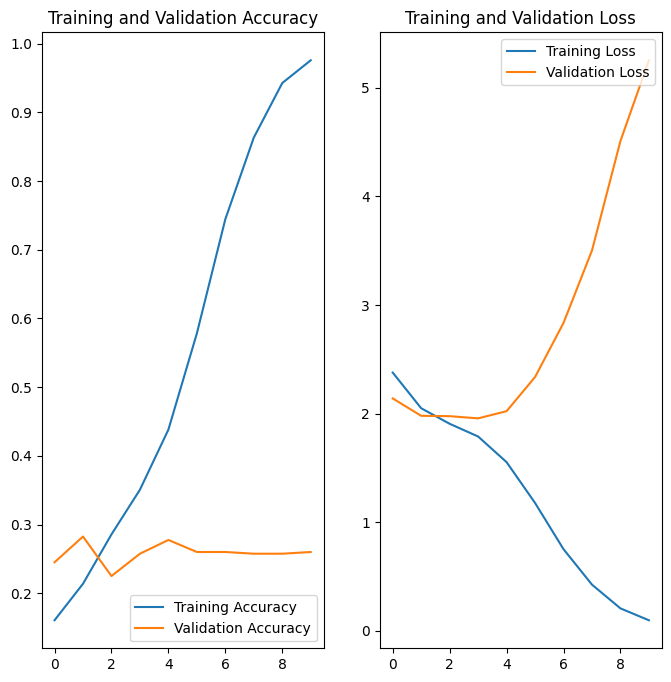

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
print(acc)

[0.12312500178813934, 0.15125000476837158, 0.1599999964237213, 0.1599999964237213, 0.1599999964237213, 0.1599999964237213, 0.1599999964237213, 0.1599999964237213, 0.1599999964237213, 0.1599999964237213]


# Section 4: Pre-Intermediate Students/Researchers

Open this section if you have some working knowledge of machine learning but haven't implemented that many models yourself. You will try to use a framework of a model I made, weaking various numbers or adding more layers, to try to come up with a good model. This is probably a good place for beginners to start too, but you can always go to the cell below if you get very stuck or are very lost.

I will give you a slightly more detailed outline for building and testing a model. Try to figure out a good set of layers with appropriate parameters. The best valdidation accuracy I could get is about 60%, but if you get to 30% with a simple model that would be quite successful!

The outline is a sequential model, which stacks a bunch of layers on top of eachother. In this section, I give a basic outline of how to build up these layers. You can see more available options for layers and the documentation for what these numbers mean [here](
https://www.tensorflow.org/api_docs/python/tf/keras/layers)

If you want some basic advice, but no specifics, here is an [article](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7) which talks about how you might design a CNN architecture.


In [11]:
model = Sequential([
    # This layer normalizes the data, making training more efficient
    layers.Rescaling(1./255, input_shape=(img_height, img_width, channels)),

    # Here is an example of an architecture that's a good starting place.
    # The ellipses are where you need to write a number that specifies how
    # many kernels each convolutional layer makes. Ask me if you don't know
    # what this means and I can explain. You can fiddle with these numbers
    # based on the guidance in the second link from the text just above this
    # cell. You can also see how I've structured this network, in rough terms,
    # so you should experiment by adding or removing some layers if you like!
    layers.Conv2D(..., (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(..., (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(..., (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(..., activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

TypeError: '<=' not supported between instances of 'ellipsis' and 'int'

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Let's see how good we did!

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

You might notice that despite our best efforts, it's really hard to get a good validation accuracy using this kind of network. Open the cell 2 below this one (Strats to Avoid Overfitting) to learn about some strategies that people use to overcome this "overfitting barrier".

# Section 5: Beginners

Open this section if you are a beginner and don't really know how to start. This will give you basically the full solution and you can try taking each line apart and seeing what it does. Hopefully this will give you an understanding of why we structure models the way we do, and you can fiddle with and tweak it to see what makes it work better!

I will give you a complete outline of a model that will get a somewhat decent validation accuracy. By decent, I mean 30% - but keep in mind that my best attempt got to ~60% at best and state-of-the-art papers analyzing this sample reach 80-90% at most!

The outline is a sequential model, which stacks a bunch of layers on top of eachother. In this section, I show you how to build up these layers. You can see more available options for layers and the documentation for what these numbers mean [here](
https://www.tensorflow.org/api_docs/python/tf/keras/layers)

If you want some basic advice, but no specifics, here is an [article](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7) which talks about how you might design a CNN architecture.


In [59]:
model = Sequential([
    # This layer normalizes the data, making training more efficient
    layers.Rescaling(1./255, input_shape=(img_height, img_width, channels)),

    # Here is an example of an architecture that's a good starting place.
    # Try to dig through some of the documentation and understand what each
    # line does. If you get stuck or are very confused, raise your hand
    # and I will happily explain anything! But if you can learn it yourself,
    # I think it'll stick even better, so give it your best shot. Feel free
    # to fiddle with the numbers once you understand what they do! You can also
    # see how I've structured this network, in rough terms, so you should
    # experiment by adding or removing some layers if you like!
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (4, 4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [60]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 124, 124, 64)      32832     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 58, 58, 128)     

In [62]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
50/50 [==============================] - 7s 93ms/step - loss: 2.2762 - accuracy: 0.1525 - val_loss: 2.1934 - val_accuracy: 0.1700
Epoch 2/10
50/50 [==============================] - 4s 75ms/step - loss: 2.1398 - accuracy: 0.2069 - val_loss: 2.0651 - val_accuracy: 0.2275
Epoch 3/10
50/50 [==============================] - 4s 72ms/step - loss: 1.9240 - accuracy: 0.2650 - val_loss: 1.9319 - val_accuracy: 0.2800
Epoch 4/10
50/50 [==============================] - 4s 76ms/step - loss: 1.6387 - accuracy: 0.4194 - val_loss: 1.8048 - val_accuracy: 0.3725
Epoch 5/10
50/50 [==============================] - 4s 74ms/step - loss: 1.2214 - accuracy: 0.5619 - val_loss: 1.9127 - val_accuracy: 0.3500
Epoch 6/10
50/50 [==============================] - 4s 74ms/step - loss: 0.7759 - accuracy: 0.7269 - val_loss: 2.3103 - val_accuracy: 0.3425
Epoch 7/10
50/50 [==============================] - 4s 74ms/step - loss: 0.3868 - accuracy: 0.8756 - val_loss: 3.0157 - val_accuracy: 0.3500
Epoch 8/10
50

Let's see how good we did!

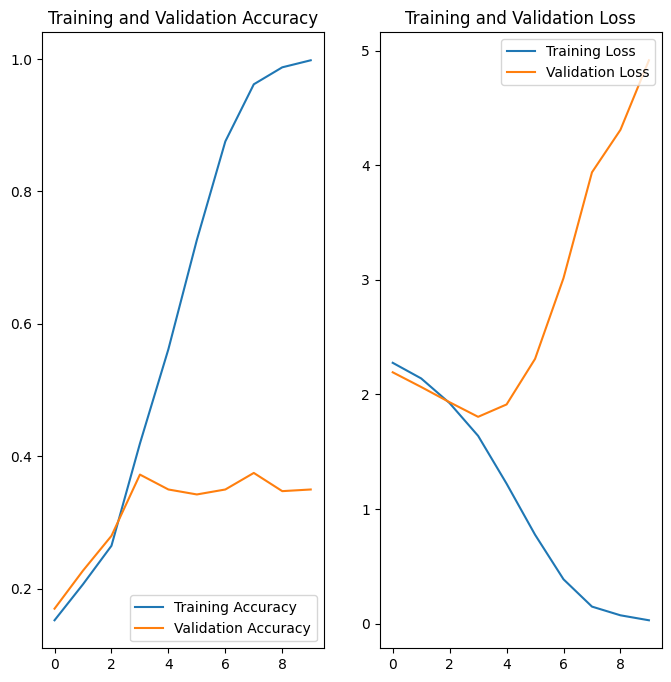

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

You might notice that despite our best efforts, it's really hard to get a good validation accuracy using this kind of network. Open the next cell to learn about some strategies that people use to overcome this "overfitting barrier".

# Some Techniques to Avoid Overfitting
Open this cell if you have gotten a somewhat successful model but are running into the issue of overfitting. You can implement some of these strategies in order to try taking your training further.

Our models are hitting plateaus because our model is getting better and better at fitting the training data, but it's not necessarily getting better at fitting the testing data, or indeed the general population of galaxies, as a whole. You might recognize this problem as overfitting. Our models are learning features of the specific set of galaxies it's training on instead of general features common to all galaxies. We will use a few strategies to try and overcome this.

One strategy is data augmentation, in which we will kind of distort some of our training data in order to "confuse" the model. This distortion will mean that every time the model trains, the training data is slightly different, and hopefully this will reduce overfitting.

Another very common strategy is dropout. At each stage of training, we will occasionally "kill off" some neurons. This sounds bad, but in actuality, this adds some randomness to the way the input is processed. The end result is also a reduction in overfitting.

In [64]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
# Augmented versions of the same galaxy
plt.figure(figsize=(5, 5))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
plt.tight_layout()

In [70]:
# An example of how you might implement augmentation and dropout into your model
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [71]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [72]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 rescaling_19 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_50 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                               

In [73]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
50/50 [==============================] - 5s 67ms/step - loss: 2.2589 - accuracy: 0.1525 - val_loss: 2.1594 - val_accuracy: 0.2175
Epoch 2/20
50/50 [==============================] - 3s 66ms/step - loss: 2.0588 - accuracy: 0.2362 - val_loss: 1.9598 - val_accuracy: 0.3000
Epoch 3/20
50/50 [==============================] - 3s 65ms/step - loss: 1.9081 - accuracy: 0.2800 - val_loss: 1.9040 - val_accuracy: 0.3100
Epoch 4/20
50/50 [==============================] - 3s 64ms/step - loss: 1.8162 - accuracy: 0.3131 - val_loss: 1.9081 - val_accuracy: 0.2950
Epoch 5/20
50/50 [==============================] - 3s 64ms/step - loss: 1.8039 - accuracy: 0.3200 - val_loss: 1.8812 - val_accuracy: 0.3150
Epoch 6/20
50/50 [==============================] - 3s 67ms/step - loss: 1.7295 - accuracy: 0.3469 - val_loss: 1.8247 - val_accuracy: 0.3400
Epoch 7/20
50/50 [==============================] - 3s 68ms/step - loss: 1.6596 - accuracy: 0.4075 - val_loss: 1.7642 - val_accuracy: 0.3800
Epoch 8/20
50

Let's see how much better our model does with these techniques!

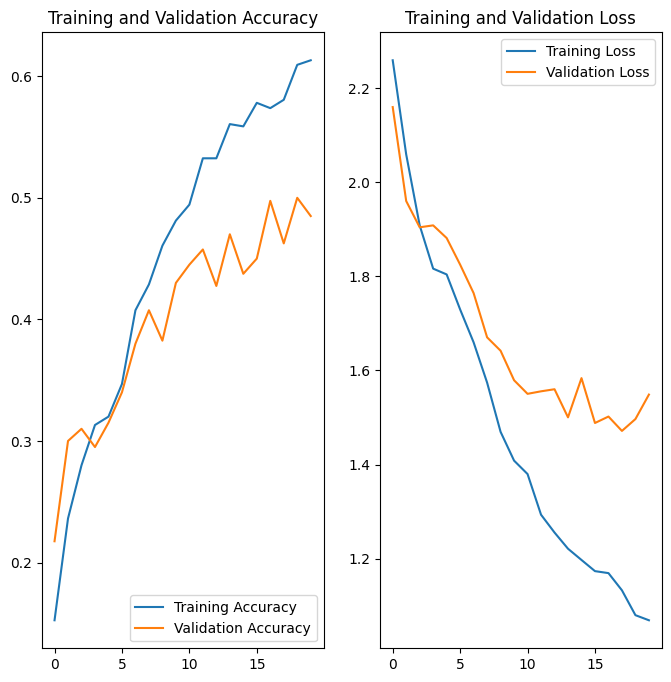

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Using a Pre-trained model
Only open this once you're completely done with the whole rest of the notebook. This is the solution I used to get a ~50-60% validation accuracy.

In [ ]:
# These are pre-trained sophisticated models which we can use instead of our own architecture
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as preprocess_x
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_r

In [ ]:
model = Sequential()

base_model = InceptionResNetV2(weights='imagenet', input_shape=(256, 256, 3), include_top=False)
# base_model = Xception(weights='imagenet', input_shape=(256, 256, 3), include_top=False)

# Freeze the layers of the pre-trained ResNet50 model
for layer in base_model.layers:
    layer.trainable = False

model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

input_layer = layers.Input(shape=(256, 256, 3))
x = preprocess_r(input_layer)
# x = preprocess_x(input_layer)
x = model(x)
model = Model(inputs=input_layer, outputs=x)

In [ ]:
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()